# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import chaospy as cp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from scipy.spatial import Delaunay

import qcodes
from qcodes.dataset import (
    LinSweep,
    TogetherSweep,
    do1d,
    do2d,
    dond,  
    Measurement,
    load_or_create_experiment,
    plot_dataset,
    initialise_or_create_database_at
)

import datetime

# Connect to Station

In [3]:
# # Load in Station
# station = qcodes.Station(config_file='../station_config.yml')
# station.load_instrument('sim900')
# station.load_instrument('agilent')

In [4]:
# today_date = datetime.date.today().strftime("%Y-%m-%d")
# initialise_or_create_database_at(f"~/experiments_{today_date}.db")

# sample_name = 'SHT 2AB'
# initialization_exp = load_or_create_experiment('Initialization Experiment', sample_name)

In [5]:
# station.sim900.set_smooth({
#     'S': 0,
#     'LB': 0,
#     'RB': 0,
#     'STR': 0,
#     'STL': 0,
#     'P': 0
# })
# station.sim900.print_readable_snapshot()

# Step (0): Device type & Bounds

Specify device type and the bounds of the voltages

In [6]:
 # Based on https://arxiv.org/pdf/2107.12975.pdf, top right of page 4

# MAX VOLTAGE JUST IN MAGNITUDE!
LB_max_mag = 1 # V
RB_max_mag = LB_max_mag 

# electrons (e) vs holes (h), accumulation (acc) vs depletion (dep)
charge_carrier = 'h'
gate_operation = 'acc'

if (charge_carrier, gate_operation) == ('e', 'acc'):
    LB_bounds = (0, +1 * LB_max_mag)
    RB_bounds = (0, +1 * RB_max_mag)
    origin = (+1 * LB_max_mag, +1 * RB_max_mag)
    quadrant = 1
if (charge_carrier, gate_operation) == ('e', 'dep'):
    LB_bounds = (-1 * LB_max_mag, 0)
    RB_bounds = (-1 * RB_max_mag, 0)
    origin = (0, 0)
    quadrant = 3
if (charge_carrier, gate_operation) == ('h', 'acc'):
    LB_bounds = (-1 * LB_max_mag, 0)
    RB_bounds = (-1 * RB_max_mag, 0)
    origin = (-1 * LB_max_mag, -1 * RB_max_mag)
    quadrant = 3
if (charge_carrier, gate_operation) == ('h', 'dep'):
    LB_bounds = (0, +1 * LB_max_mag)
    RB_bounds = (0, +1 * RB_max_mag)
    origin = (0, 0)
    quadrant = 1
max_boundary = sorted(LB_bounds, key=abs)[0], sorted(RB_bounds, key=abs)[0]

print(f"Bounds for LB (V): {LB_bounds}")
print(f"Bounds for RB (V): {RB_bounds}")
print(f"Origin (V): {origin}")
print(f"Max Boundary: {max_boundary}")


Bounds for LB (V): (-1, 0)
Bounds for RB (V): (-1, 0)
Origin (V): (-1, -1)
Max Boundary: (0, 0)


Now that we know safe voltages, apply a small accumulation voltage and SD bias.

In [7]:
V_bias = 0.01 # V
V_acc = 0.2 # V

sensitivity = 1e-6
I_bias = 0

Next we need to measure the noise floor of our device. We do this by ramping to origin and measuring.

In [ ]:
I_max = 1
I_min = 0
I_range = I_max - I_min

## Step (1): Defining Single Quantum Dot

Define sample points to define paths where we will measure current through the device along.

In [8]:
# Set the number of points in the sequence
num_points = 50

distribution = cp.Iid(cp.Uniform(*LB_bounds), 2)
sample_voltages = distribution.sample(num_points, rule="sobol").T

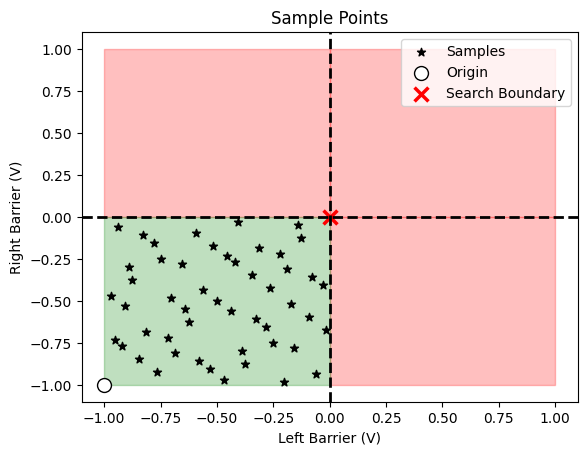

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between([0, -1 * LB_max_mag], 0, RB_max_mag, color='red', alpha=0.25)
ax.fill_between([0, LB_max_mag], -RB_max_mag, 0, color='red', alpha=0.25)
if quadrant == 1:
    ax.fill_between([0, -1 * LB_max_mag], -RB_max_mag, 0, color='red', alpha=0.25)
    ax.fill_between([0, 1 * LB_max_mag], 0, RB_max_mag, color='green', alpha=0.25)
else:
    ax.fill_between([0, -1 * LB_max_mag], -RB_max_mag, 0, color='green', alpha=0.25)
    ax.fill_between([0, 1 * LB_max_mag], 0, RB_max_mag, color='red', alpha=0.25)
ax.axhline(0, color='black', linewidth=2, linestyle='--')
ax.axvline(0, color='black', linewidth=2, linestyle='--')
ax.scatter(sample_voltages[:, 0], sample_voltages[:, 1], color='black', marker='*', label='Samples')
ax.scatter(origin[0], origin[1], color='white', edgecolor='black', marker='o', s=100, label='Origin')
ax.scatter(max_boundary[0], max_boundary[0], color='red', linewidths=2.5, marker='x', s=100, label='Search Boundary')
ax.set_xlabel('Left Barrier (V)')
ax.set_ylabel('Right Barrier (V)')
ax.set_title('Sample Points')
ax.legend()

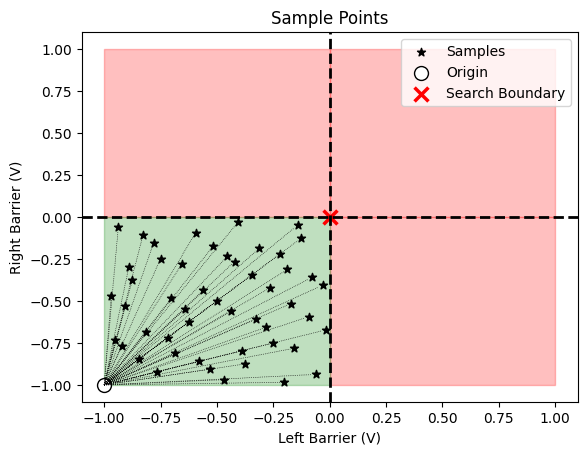

In [10]:
%matplotlib inline
# Randomly shuffle points
shuffled_voltages = (np.random.permutation(sample_voltages))

def interpolate_points(point1, point2, num_points):
    """
    Interpolate points between two given points.

    Args:
    point1 (tuple): Coordinates of the first point (x1, y1).
    point2 (tuple): Coordinates of the second point (x2, y2).
    num_points (int): Number of intermediate points to generate.

    Returns:
    numpy.ndarray: Array of interpolated points [(x1, y1), ..., (xn, yn)].
    """
    # Unpack points
    x1, y1 = point1
    x2, y2 = point2
    
    # Calculate step size for interpolation
    step_size = 1.0 / (num_points + 1)
    
    # Initialize array to store interpolated points
    interpolated_points = []
    
    # Interpolate points
    for i in range(0, num_points + 1):
        # Calculate intermediate point coordinates
        x_interpolated = x1 + i * step_size * (x2 - x1)
        y_interpolated = y1 + i * step_size * (y2 - y1)
        
        # Append intermediate point to the array
        interpolated_points.append((x_interpolated, y_interpolated))
    
    return np.array(interpolated_points).round(3)

all_paths = []
for voltage_config in shuffled_voltages:
    interpolated_path = interpolate_points(origin, voltage_config, num_points=50)
    ax.plot(interpolated_path[:,0], interpolated_path[:,1], c='black', linewidth=0.5, linestyle='dotted')
    all_paths.append(interpolated_path)
fig

Now we have all the paths we need to measure current along to start building our Gaussian surface. Pick a random path in our set of paths and go from the origin to the point. Record the current as you traverse the path and if there's current below the pinch-off threshold, mark the location of pinch off as a new point.

In [ ]:
def pinched_off():
    threshold = 0.5 / 100 # 0.5%
    return np.abs(station.agilent.volt()) < threshold * I_range

[-1.    -0.989 -0.977 -0.966 -0.955 -0.943 -0.932 -0.921 -0.909 -0.898
 -0.887 -0.875 -0.864 -0.853 -0.841 -0.83  -0.819 -0.807 -0.796 -0.785
 -0.773 -0.762 -0.751 -0.739 -0.728 -0.717 -0.705 -0.694 -0.683 -0.671
 -0.66  -0.649 -0.637 -0.626 -0.615 -0.603 -0.592 -0.581 -0.569 -0.558
 -0.547 -0.535 -0.524 -0.513 -0.501 -0.49  -0.479 -0.467 -0.456 -0.445
 -0.433] [-1.    -0.986 -0.971 -0.957 -0.942 -0.928 -0.914 -0.899 -0.885 -0.87
 -0.856 -0.842 -0.827 -0.813 -0.798 -0.784 -0.77  -0.755 -0.741 -0.726
 -0.712 -0.698 -0.683 -0.669 -0.654 -0.64  -0.626 -0.611 -0.597 -0.582
 -0.568 -0.554 -0.539 -0.525 -0.51  -0.496 -0.482 -0.467 -0.453 -0.438
 -0.424 -0.41  -0.395 -0.381 -0.366 -0.352 -0.338 -0.323 -0.309 -0.294
 -0.28 ]


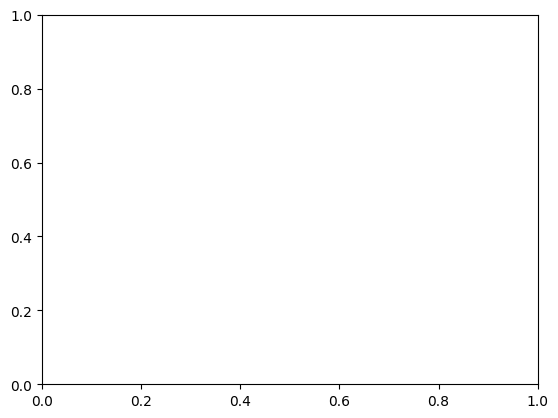

In [11]:
fig, ax = plt.subplots()

for path_num, path in enumerate(all_paths):

    path_distance_vector = np.linspace(0,1,len(path[:,0]))

    LB_path = path[:,0]
    RB_path = path[:,1]

    # QCODES 
    LB_sweep = LinSweep(station.sim900.volt_LB, LB_path[0], LB_path[-1], len(LB_path), 0.01)
    RB_sweep = LinSweep(station.sim900.volt_RB, RB_path[0], RB_path[-1], len(RB_path), 0.01)
    result = dond(
        TogetherSweep(
            LB_sweep, RB_sweep
        ),
        station.agilent.volt,
        break_condition=pinched_off,
        measurement_name=f'pinch-off-path-{path_num}',
        exp=initialization_exp,
    )

    break